# CeNN entrenada con ABC y Simplex

Entrenamiento de una CeNN utilizando el método ABC y Simplex unidos

## Librerías

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from time import time
import pandas as pd 
import cv2
import scipy.io

In [ ]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.experimental.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  "), 
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True


## Función CeNN

In [ ]:
def CeNN(matEnt, plantillas, dim, sal = None, edo = None, tmax = 5, h = 0.001):
    """
    Función que crea una Red Nueronal Celular utilizando Tensorflow
    """
    matSal = matEnt
    matEdo = matEnt
    # Crea las plantillas
    pA = np.array([[plantillas[0], plantillas[1], plantillas[2]],
                   [plantillas[3], plantillas[4], plantillas[3]],
                   [plantillas[2], plantillas[1], plantillas[0]]])
    
    pB = np.array([[plantillas[5], plantillas[6], plantillas[7]],
                   [plantillas[8], plantillas[9], plantillas[8]],
                   [plantillas[7], plantillas[6], plantillas[5]]])
    
    tA = tf.convert_to_tensor(pA, dtype = tf.float32)
    tA = tf.reshape(tA, shape = [3, 3, 1, 1])
    tB = tf.convert_to_tensor(pB, dtype = tf.float32)
    tB = tf.reshape(tB, shape = [3, 3, 1, 1])
    tI = tf.convert_to_tensor(plantillas[10], dtype = tf.float32)

    # Calcula la matriz Iij
    matIij = tf.nn.conv2d(matEnt, tB, strides = [1, 1, 1, 1], padding = "SAME")
    #matIij = tf.reshape(matIij, shape = [dim[0], dim[1]])
    matIij = tf.add(matIij, tI)

    # Inicializa la variable de tiempo
    t = 0

    # Comienza con el calculo de la CeNN
    while(t < tmax):
        # Calcula Fij
        matFij = tf.nn.conv2d(matSal, tA, strides = [1, 1, 1, 1], padding= "SAME")
        # Calcula el Estado
        matEdo = tf.add(matEdo, tf.multiply(h, tf.add(matFij, tf.subtract(matIij, matEdo))))
        # Calcula la Salida
        matSal = tf.multiply(0.5, tf.subtract(tf.abs(tf.add(matEdo, 1.0)), tf.abs(tf.subtract(matEdo, 1.0))))
        # Calcula el siguiente paso
        t = t + h
    # Redimensiona
    matSal = tf.reshape(matSal, shape = [dim[0], dim[1]])
    # Regresa la salida
    return matSal

## Funciones Simplex

In [ ]:
def reflexion(xh, r, xo):
    """
    xr = xo + r * (xo - xh)
    """
    xr = xo + r * (xo - xh)
    return xr

In [ ]:
def expansion(xr, e, xo):
    """
    xe = xo + e * (xr - xo)
    """
    xe = xo + e * (xr - xo)
    return xe

In [ ]:
def contraccion(xh, c, xo):
    """
    xc = xo + c * (xh - xo)
    """
    xc = xo + c * (xh - xo)
    return xc

In [ ]:
def satlinsJJ(x, Limites = (-1.0, 1.0)):
    y = 0.5 * (np.abs(x + Limites[1]) - np.abs(x + Limites[0]))
    return y

## Funciones ABC

In [ ]:
def best(x, fitx):
    # Centroide
    xo = np.mean(x, axis = 0)
    # Ordenamiento
    fitSort = sorted(enumerate(fitx), key=lambda z:z[1], reverse=True)
    # Indices
    indMin = fitSort[-1][0]
    indH1 = fitSort[0][0]
    indH2 = fitSort[1][0]
    # Valores Fit
    fitMin = fitSort[-1][1]
    fitH1 = fitSort[0][1]
    fitH2 = fitSort[1][1]
    # Valores X
    xMin = x[indMin]
    xH1 = x[indH1]
    xH2 = x[indH2]
    #print("fitMin = {}, fitx[ind] = {}, fitx = {}".format(fitMin, fitx[indMin], fitx))
    return [xo, indMin, xMin, fitMin, indH1, xH1, fitH1, indH2, xH2, fitH2]

In [ ]:
def correlacion(imgEnt, imgObj):
    # Convierte la imgEnt a valores entre 0 y 255
    img = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgEnt)))

    zPmean = tf.math.reduce_mean(img)
    tPmean = tf.math.reduce_mean(imgObj)

    numerador = tf.math.reduce_sum(tf.multiply(tf.subtract(img, zPmean), tf.subtract(imgObj, tPmean)))

    denA = tf.subtract(img, zPmean)
    denB = tf.subtract(imgObj, tPmean)
    denAA = tf.multiply(denA, denA)
    denBB = tf.multiply(denB, denB)
    denAAS = tf.math.reduce_sum(denAA)
    denBBS = tf.math.reduce_sum(denBB)
    denominador = tf.sqrt(tf.multiply(denAAS, denBBS))
    
    if(denominador != 0.0):
        CD = numerador / denominador
        C = CD.numpy()
    else:
        print("denominador = 0.0")
        C = -1.0

    # Asegura que no sea negativo
    #if C < 0.0:
    #    C = 1.5
    #print("C = ", C)

    return C

In [ ]:
def fitness(x):
    y = 0.0
    if(x < 0.0):
        y = 0.5 + np.abs(x)
    else:
        y = (1.0 / (1.0 + x)) - 0.5
    #print("Fitness: x = {}; y = {}".format(x, y))
    return y

## Función Main

In [ ]:
def TrainCeNN(imgEnt, imgObj, CS = 10, LimSB = 10, Limites = (-32.0, 32.0), epocas = 10, tmax = 5, h = 0.125, simplex = None):
    # ---- Parámetros del Simples ----- #
    if simplex == None:
        r = 1.5 # Positivo
        e = 2.0 # Mayor a 1
        c = 0.5 # Entre 0 y 1
    else:
        r = simplex[0]
        e = simplex[1]
        c = simplex[2]
    # ----- Preprocesamiento ----- #
    SB = int(CS / 2)
    #OB = int(CS / 2)
    OB = int(CS/2)
    #OB = SB * 2
    vecino = 0
    # Dimensiones del problema
    D = int(11)
    # Limite para ScoutBees
    L = int(11)
    # Crea los puntos iniciales con distribución uniforme
    x = np.random.uniform(low = Limites[0], high = Limites[1], size = (SB, D))
    # Vector de resultados fitness
    fitx = np.ones(SB)
    # Vectores para los EmployedBees
    v = np.copy(x)
    fitv = np.copy(fitx)
    # Valores del mejor
    mej = 1.0
    fitm = 1.0
    # Vector de TrialCounter para la fase de ScoutBees
    TrialCounter = np.zeros(SB)

    # Vectores para el Porcentaje
    vecPor = np.linspace(0, epocas, num = 100)
    puntPor = 0

    # Convierte la matriz de entrada a tensor
    dim = imgEnt.shape

    # Obtiene el valor de matObj
    matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)
    #matObj = tf.reshape(matObj, shape = [1, dim[0], dim[1], 1])

    # Matriz de entrada con valores CeNN
    matEntCeNN = 1.0-(2.0 * imgEnt) / 255.0
    matEntCeNN = tf.convert_to_tensor(matEntCeNN, dtype = tf.float32)
    matEntCeNN = tf.reshape(matEntCeNN, shape = [1, dim[0], dim[1], 1])

    # Matriz para guardar los datos
    matGuardar = np.array([["Train", "Ruido0_120x120_50"],
                           ["Obj", "Objetivo0_120x120"],
                           ["CS", CS], 
                           ["LimSB", LimSB], 
                           ["Limite inf", Limites[0]], 
                           ["Limite sup", Limites[1]],
                           ["tmax", tmax],
                           ["h", h],
                           ["L", L],
                           ['Epoca', 'Fitness']])

    #  ----- Primer selección del mejor ------ #
    for i in range(SB):
        imgCeNN = CeNN(matEntCeNN, x[i], dim, tmax = tmax, h = h)
        corr = correlacion(imgCeNN, matObj)
        #print("Corr = {}".format(corr))
        fitx[i] = fitness(corr)
        #fitx[i] = corr
        #print("fitx = {}".format(fitx[i]))

    # ----- Encuentra el primer mejor Global ----- #
    [xo, indMin, xMin, fitMin, indH1, xH1, fitH1, indH2, xH2, fitH2] = best(x, fitx)
    fitGlobal = np.copy(fitMin)
    xGlobal = np.copy(xMin)
    indGlobal = np.copy(indMin)

    # Empieza a contar el tiempo para la primera epoca
    start_time = time()

    # ----- Comienza el Algoritmo ABC ----- #
    for n in range(int(epocas)):
        # ----- Employed Bees ----- #
        for i in range(SB):
            # Indice k aleatorio
            k = np.random.randint(SB)
            # Comprueba que k sea diferente de i
            while i == k:
                k = np.random.randint(SB)
            # Valor j aleatorio
            j = np.random.randint(D)
            # Valor de phi
            phi = np.random.uniform(low = -1.0, high = 1.0)
            # Busca en las cercanias y comprueba que no salga de los limites
            vecino = x[i, j] + phi * (x[i, j] - x[k, j])
            v[i, j] = satlinsJJ(vecino, Limites=Limites)
            # Calcula la correlación del Emplyed Bee
            imgCeNN = CeNN(matEntCeNN, v[i], dim, tmax = tmax, h = h)
            corr = correlacion(imgCeNN, matObj)
            fitv[i] = fitness(corr) # Aquí va la función fitness
            #fitv[i] = corr
            #print("corr = {}, fitv[{}] = {}".format(corr, i, fitv[i]))
            # Aplica selección Greedy
            if(fitv[i] < fitx[i]):
                #print("fitv[{}] = {}, fitx[{}] = {}".format(i, fitv[i], i, fitx[i]))
                x[i] = np.copy(v[i])
                fitx[i] = np.copy(fitv[i])
                TrialCounter[i] = 0
            else:
                TrialCounter[i] = TrialCounter[i] + 1
        
        # ----- Onlooker Bees ----- #
        for i in range(OB):
            [xo, indMin, xMin, fitMin, indH1, xH1, fitH1, indH2, xH2, fitH2] = best(x, fitx)
            # --- Reflexión --- #
            xr = reflexion(xH1, r, xo)
            xr = satlinsJJ(xr, Limites=Limites)
            imgCeNN = CeNN(matEntCeNN, xr, dim, tmax = tmax, h = h)
            corr = correlacion(imgCeNN, matObj)
            yr = fitness(corr)
            if (yr < fitMin):
                #print("Mejora")
                # --- Expansión --- #
                xe = expansion(xr, e, xo)
                xe = satlinsJJ(xe, Limites=Limites)
                imgCeNN = CeNN(matEntCeNN, xe, dim, tmax = tmax, h = h)
                corr = correlacion(imgCeNN, matObj)
                ye = fitness(corr)
                #TrialCounter[indH1] = 0
                #TrialCounter[indH2] = TrialCounter[indH2] + 1
                if (ye < yr):
                    x[indH1] = np.copy(xe)
                    fitx[indH1] = np.copy(ye)
                    x[indH2] = np.copy(xr)
                    fitx[indH2] = np.copy(yr)
                    TrialCounter[indH1] = 0
                    TrialCounter[indH2] = 0
                else:
                    x[indH1] = np.copy(xr)
                    fitx[indH1] = np.copy(yr)
                    TrialCounter[indH1] = 0
                    TrialCounter[indH2] = TrialCounter[indH2] + 1
            else:
                if (yr < fitH2):
                    x[indH1] = np.copy(xr)
                    fitx[indH1] = np.copy(yr)
                    TrialCounter[indH1] = 0
                    TrialCounter[indH2] = TrialCounter[indH2] + 1
                else:
                    # --- Contracción --- #
                    xc = contraccion(xH1, c, xo)
                    xc = satlinsJJ(xc, Limites=Limites)
                    imgCeNN = CeNN(matEntCeNN, xc, dim, tmax = tmax, h = h)
                    corr = correlacion(imgCeNN, matObj)
                    yc = fitness(corr)
                    if (yc < fitH2):
                        x[indH1] = np.copy(xc)
                        fitx[indH1] = np.copy(yc)
                        TrialCounter[indH1] = 0
                        TrialCounter[indH2] = TrialCounter[indH2] + 1
                    else:
                        # Valor j aleatorio
                        j = np.random.randint(D)
                        #print("xGlobal = {}".format(xGlobal))
                        #print("j = {}, xGlobal[{}] = {}".format(j, j, xGlobal[j]))
                        xH1 = np.copy(xGlobal)
                        #xH1[j] = xH1[j] + (xH1[j] - xMin[j]) * np.random.uniform(low = -1.0, high = 1.0)
                        xH1[j] = xH1[j] + np.random.uniform(low = -1.0, high = 1.0)
                        xH1 = satlinsJJ(xH1, Limites=Limites)
                        #print("xc = {}".format(xc))
                        imgCeNN = CeNN(matEntCeNN, xH1, dim, tmax = tmax, h = h)
                        corr = correlacion(imgCeNN, matObj)
                        fitH1 = fitness(corr)
                        x[indH1] = np.copy(xH1)
                        fitx[indH1] = np.copy(fitH1)
                        TrialCounter[indH2] = TrialCounter[indH2] + 1
                        TrialCounter[indH1] = 0

        # ----- Memoriza el mejor ----- #
        [xo, indMin, xMin, fitMin, indH1, xH1, fitH1, indH2, xH2, fitH2] = best(x, fitx)
        if(fitMin < fitGlobal):
            #print("Pre: fitGlobal = {}; fitH1 = {}".format(fitGlobal, fitH1))
            #print("xH1 = {}".format(xH1))
            fitGlobal = np.copy(fitMin)
            xGlobal = np.copy(xMin)
            indGlobal = np.copy(indMin)
            #print("Pos: fitGlobal = {}; fitH1 = {}".format(fitGlobal, fitH1))
            #print("xGlobal = {}".format(xGlobal))

        # ----- Scout Bees ----- #
        for i in range(SB):
            if(TrialCounter[i] > L):
                x[i] = np.random.uniform(low = Limites[0], high = Limites[1], size = (1, D))
                imgCeNN = CeNN(matEntCeNN, x[i], dim, tmax = tmax, h = h)
                corr = correlacion(imgCeNN, matObj)
                fitx[i] = fitness(corr) # Aquí va la función fitness
                #fitx[i] = corr
                TrialCounter[i] = 0
                #print("Reinicio: ", i)

        # ----- Muestra el mejor has ahora ----- #
        if(n >= vecPor[puntPor]):
            elapsed_time = time() - start_time
            print("Epoch: {:5d} de {:5d}; {:4d} of 100%; Fitness = {:3.9f}; Elapsed time: {:3.8f};".format(n+1, epocas, puntPor+1, fitGlobal, elapsed_time))
            puntPor = puntPor + 1
            start_time = time()

        # ----- Guarda los resultados ----- #
        matGuardar = np.append(matGuardar, [[n, fitGlobal]], axis = 0)

    print("Epoch: {:5d} de {:5d}; {:4d} of 100%; Fitness = {:3.9f}; Elapsed time: {:3.8f};".format(n+1, epocas, puntPor+1, fitGlobal, elapsed_time))
    #print("xGlobal = {}, fitGlobal = {}".format(xGlobal, fitGlobal))
    #imgCeNN = CeNN(matEntCeNN, xGlobal, dim, tmax = tmax, h = h)
    #corr = correlacion(imgCeNN, matObj)
    #print("corr = ", corr)

    # ----- Guarda el archivo ----- #
    #print(matGuardar)
    #np.savetxt("matGuardar.csv", matGuardar, delimiter=",")
    pd.DataFrame(matGuardar).to_csv("ABC_Simplex.csv")

    # ----- Finaliza ----- #
    return [xGlobal, fitGlobal]

# Entrenamiento

Celdas para el entrenamiento de la CeNN

## Entrenar

In [ ]:
# ----- Leer las matrices CeNN ----- #
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Ruido0_120x120_50.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_120x120.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)

# Paso de tiempo y tiempo máximo de procesamiento
h = 0.03125
tmax = 1.1

# Parametros para el entrenamiento ABC
CS = 24*4
LimSB = 12
Limites = (-64.0, 64.0)
epocas = 1000

# Parametros simplex
simplex = (1.0, 2.0, 0.5)

# Entrenamiento
print("Comienza el entrenamiento")
y = TrainCeNN(imgEnt, imgObj, LimSB = LimSB, CS = CS, Limites = Limites, epocas = epocas, tmax = tmax, h = h, simplex = simplex)

Comienza el entrenamiento
Epoch:     1 de  1000;    1 of 100%; Fitness = 0.070647608; Elapsed time: 1.11436486;
Epoch:    12 de  1000;    2 of 100%; Fitness = 0.027180060; Elapsed time: 13.25981688;
Epoch:    22 de  1000;    3 of 100%; Fitness = 0.026640305; Elapsed time: 15.74577379;
Epoch:    32 de  1000;    4 of 100%; Fitness = 0.026636205; Elapsed time: 18.61512661;
Epoch:    42 de  1000;    5 of 100%; Fitness = 0.026636205; Elapsed time: 17.85209918;
Epoch:    52 de  1000;    6 of 100%; Fitness = 0.026578634; Elapsed time: 16.91365409;
Epoch:    62 de  1000;    7 of 100%; Fitness = 0.026578600; Elapsed time: 18.17409921;
Epoch:    72 de  1000;    8 of 100%; Fitness = 0.026578600; Elapsed time: 17.48408175;
denominador = 0.0
Epoch:    82 de  1000;    9 of 100%; Fitness = 0.026578600; Elapsed time: 17.38705754;
Epoch:    92 de  1000;   10 of 100%; Fitness = 0.026578600; Elapsed time: 16.82808256;
Epoch:   103 de  1000;   11 of 100%; Fitness = 0.026520975; Elapsed time: 19.26726604;


## Resultado

Plantillas: [ -0.10670936  20.38874436 -21.45379781  12.59946828  54.3960652
  -1.07520018   2.6313561   27.07886721   3.47226092  59.06013202
 -18.97814193]
Tiempo máximo: 1.1. Paso de tiempo: 0.03125
Finess: 0.026308993641270373
Correlación: 0.9000245332717896
CS = 96, LimSB = 12, Limites = (-64.0, 64.0), epocas = 1000


Text(0.5, 1.0, 'Entrenado')

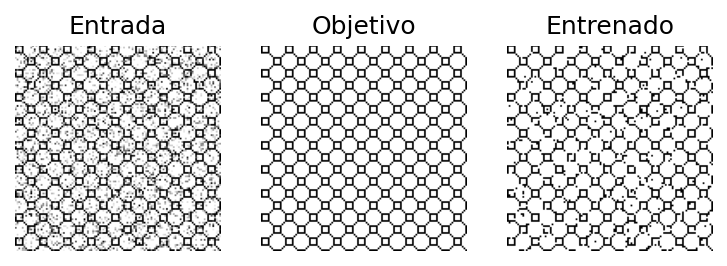

In [ ]:
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Ruido0_120x120_50.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_120x120.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)
# Valores obtenidos
p = y[0]
fit = y[1]
dim = imgEnt.shape
# Obtiene el valor de matObj
matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)
#matObj = tf.reshape(matObj, shape = [1, dim[0], dim[1], 1])
# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])
# Validación
imgCeNN = CeNN(matEntR, p, dim, tmax = tmax, h = h)
# Correlación
#imgCeNN = tf.reshape(imgCeNN, shape = [dim[0], dim[1]])
corr = correlacion(imgCeNN, matObj)
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN)))
#imgCeNN = tf.reshape(imgCeNN, shape = [dim[0], dim[1]])
matSal = imgCeNN.numpy()

print("Plantillas: {}".format(p))
print("Tiempo máximo: {}. Paso de tiempo: {}".format(tmax, h))
print("Finess: {}".format(fit))
print("Correlación: {}".format(corr))
print("CS = {}, LimSB = {}, Limites = {}, epocas = {}".format(CS, LimSB, Limites, epocas))

fig, axes = plt.subplots(nrows = 1, ncols = 3, dpi = 200)
axes[0].imshow(imgEnt, cmap = 'gray')
axes[0].axis('off')
axes[0].set_title("Entrada")
axes[1].imshow(imgObj, cmap = 'gray')
axes[1].axis('off')
axes[1].set_title("Objetivo")
axes[2].imshow(matSal, cmap = 'gray')
axes[2].axis('off')
axes[2].set_title("Entrenado")

# Validación

Correlación Train = 0.23806683719158173
Correlación Global = 0.9006519317626953
Correlación Paper = 0.8765122890472412


(-0.5, 164.5, 164.5, -0.5)

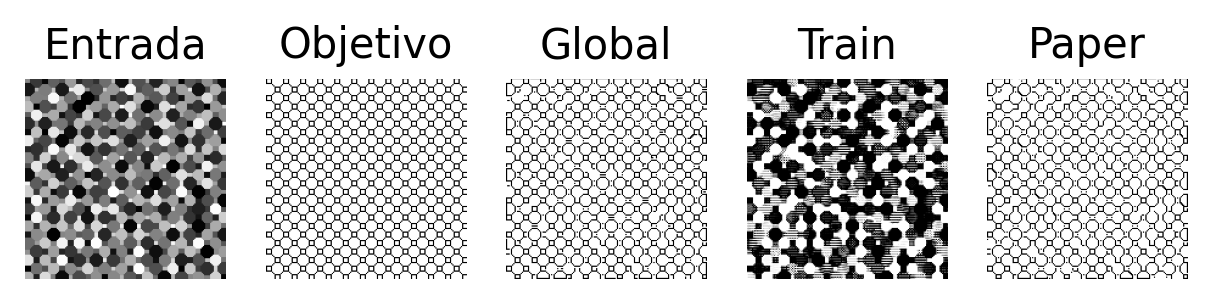

In [ ]:
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Grises0_165x165_paso2.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_165x165.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)
imgObj = -1.0*imgObj
# Valores obtenidos

dim = imgEnt.shape
# Obtiene el valor de matObj
matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)

# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])


# ---- Train ----- #
pT = y[0]
fitT = y[1]
tmaxT = tmax
hT = h
imgCeNN = CeNN(matEntR, pT, dim, tmax = tmax, h = h) # CeNN
fitT = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgT = imgCeNN.numpy() # Guarda en formato numpy

# ----- Global ----- #
#pG =  np.array([4.93488187e-02, -2.26484305e-01, -1.11100007e-02, -1.26270159e-02, 4.26564270e+01, -2.59617261e-02, -3.19685278e+01, 6.24045056e-02, -1.00934957e+01, 4.28123521e+01, -2.09221465e-01])
#pG =  np.array([-0.14966108, 0.53145529, -0.16889381, -0.11542056, 63.58460309, 0.1252678, -29.91468367, 0.20578403, -23.72943881, 44.04818551, -0.33098828])
#pG = np.array([2.35406331, -9.86198524, -4.12561655, -10.46921506, 60.8963263, -7.3327797, -10.36892724, -2.14952112, -20.72864443, 62.47862202, -12.213750244021483])
pG = np.array([0.17000624, -1.66439731, -2.26394305, 1.64457857, 58.33307036, 0.54011119, -21.21555131, 2.33031004, -32.58411392, 49.16729475, -1.64168747])
hG = 0.03125
tmaxG = 1.1
imgCeNN = CeNN(matEntR, pG, dim, tmax = tmaxG, h = hG) # CeNN
fitG = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgG = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper ----- #
pP = np.array([-0.2481, -5.4392, -1.2947, -7.3103, 62.7200, -0.0051, 0.0610, 0.1331, -0.0739, -34.2720, -1.6937])
hP = 0.3
tmaxP = 9.0
imgCeNN = CeNN(matEntR, pP, dim, tmax = tmaxP, h = hP) # CeNN
fitP = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgP = imgCeNN.numpy() # Guarda en formato numpy

# ----- Imprime valores ----- #
print("Correlación Train = {}".format(fitT))
print("Correlación Global = {}".format(fitG))
print("Correlación Paper = {}".format(fitP))

fig, axes = plt.subplots(nrows = 1, ncols = 5, dpi = 250)
axes[0].imshow(imgEnt, cmap = 'gray')
axes[0].set_title("Entrada")
axes[0].axis('off')
axes[1].imshow(imgObj, cmap = 'gray')
axes[1].set_title("Objetivo")
axes[1].axis('off')
axes[3].imshow(imgT, cmap = 'gray')
axes[3].set_title("Train")
axes[3].axis('off')
axes[2].imshow(imgG, cmap = 'gray')
axes[2].set_title("Global")
axes[2].axis('off')
axes[4].imshow(imgP, cmap = 'gray')
axes[4].set_title("Paper")
axes[4].axis('off')

# Pruebas

Plantillas: [-10.396    1.2147 -10.4482 -13.4523  62.4621   4.6734 -20.8402  -8.4367
 -12.863   61.9943 -35.1705]
Tiempo máximo: 1.1. Paso de tiempo: 0.03125
Correlación: 0.7901328802108765


True

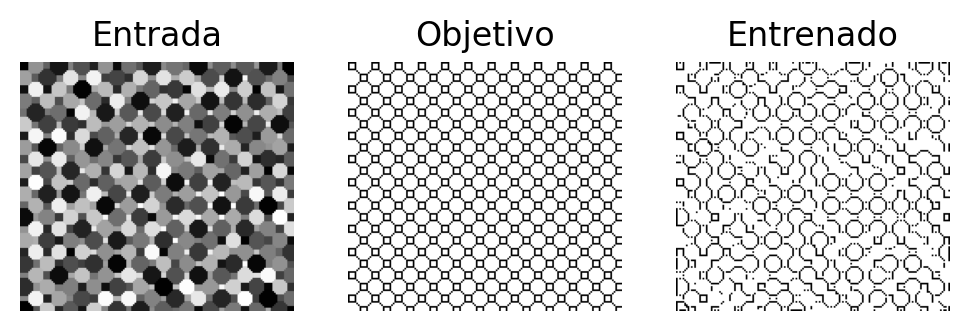

In [ ]:
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Grises0_150x165_paso2.png")
#imgEnt = Image.open("./Imagenes/Ruido0_120x120_50.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_150x165.png")
#imgObj = Image.open("./Imagenes/Objetivo0_120x120.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)
# Valores obtenidos
# pG = np.array([0.17000624, -1.66439731, -2.26394305, 1.64457857, 58.33307036, 0.54011119, -21.21555131, 2.33031004, -32.58411392, 49.16729475, -1.64168747])
pG = np.array([-10.396, 1.2147, -10.4482, -13.4523, 62.4621, 4.6734, -20.8402, -8.4367, -12.8630, 61.9943, -35.1705]) # Detector de bordes CEIAAT
# pG = np.array([-9.1103, 3.7785, -14.1810, -12.0083, 64.0000, 25.6479, 15.3484, 22.2699, 28.4184, 59.4597, -7.5525]) # Removedor de ruido CEIAAT
hG = 0.03125
tmaxG = 1.1
dim = imgEnt.shape
# Obtiene el valor de matObj
matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)
#matObj = tf.reshape(matObj, shape = [1, dim[0], dim[1], 1])
# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])
# Validación
imgCeNN = CeNN(matEntR, pG, dim, tmax = tmaxG, h = hG)
# Correlación
#imgCeNN = tf.reshape(imgCeNN, shape = [dim[0], dim[1]])
corr = correlacion(imgCeNN, matObj)
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN)))
#imgCeNN = tf.reshape(imgCeNN, shape = [dim[0], dim[1]])
matSal = imgCeNN.numpy()

print("Plantillas: {}".format(pG))
print("Tiempo máximo: {}. Paso de tiempo: {}".format(tmaxG, hG))
#print("Finess: {}".format(fit))
print("Correlación: {}".format(corr))
#print("CS = {}, LimSB = {}, Limites = {}, epocas = {}".format(CS, LimSB, Limites, epocas))

fig, axes = plt.subplots(nrows = 1, ncols = 3, dpi = 200)
axes[0].imshow(imgEnt, cmap = 'gray')
axes[0].axis('off')
axes[0].set_title("Entrada")
axes[1].imshow(imgObj, cmap = 'gray')
axes[1].axis('off')
axes[1].set_title("Objetivo")
axes[2].imshow(matSal, cmap = 'gray')
axes[2].axis('off')
axes[2].set_title("Entrenado")

# guardar la imagen en formato JPG
cv2.imwrite('EDInput.png', imgEnt)
cv2.imwrite('EDObjective.png', imgObj)
cv2.imwrite('EDOut.png', matSal)

Correlación Global = 0.9005467891693115
Correlación Selami = 0.8764102458953857
Correlación DE-CNN = 0.07867016643285751
Correlación ES-CNN = 0.8374584317207336
Correlación Chua-CNN = 0.4806790351867676


True

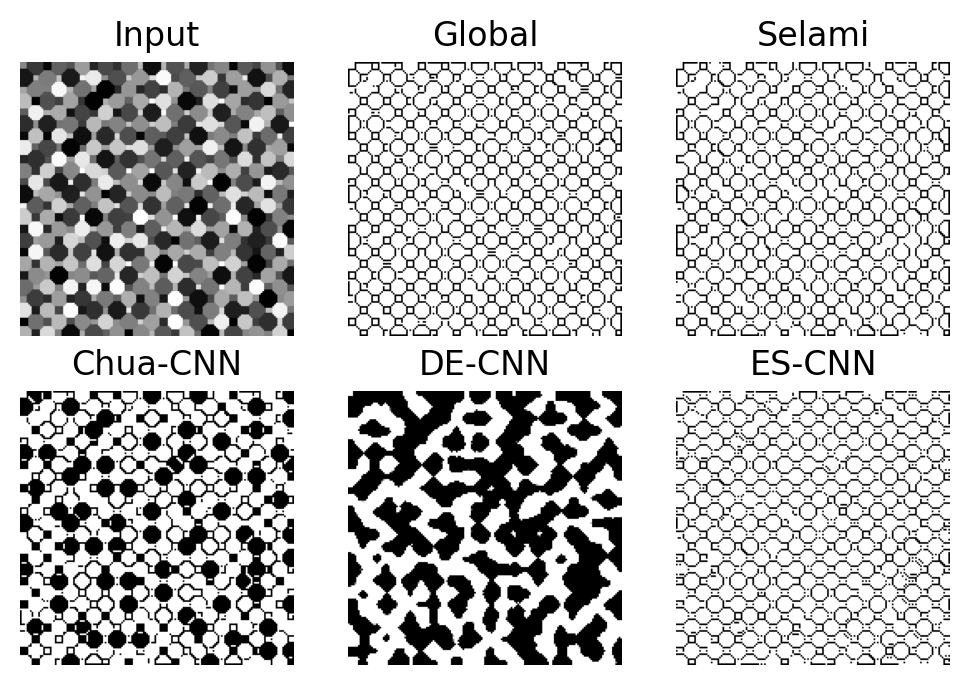

In [ ]:
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Grises0_165x165_paso2.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_165x165.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)
#imgObj = -1.0*imgObj
# Valores obtenidos

dim = imgEnt.shape
# Obtiene el valor de matObj
matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)

# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])


# ----- Global ----- #
#pG =  [4.93488187e-02, -2.26484305e-01, -1.11100007e-02, -1.26270159e-02, 4.26564270e+01, -2.59617261e-02, -3.19685278e+01, 6.24045056e-02, -1.00934957e+01, 4.28123521e+01, -2.09221465e-01]
#pG =  np.array([-0.14966108, 0.53145529, -0.16889381, -0.11542056, 63.58460309, 0.1252678, -29.91468367, 0.20578403, -23.72943881, 44.04818551, -0.33098828])
pG = np.array([0.17000624, -1.66439731, -2.26394305, 1.64457857, 58.33307036, 0.54011119, -21.21555131, 2.33031004, -32.58411392, 49.16729475, -1.64168747]) # good
hG = 0.03125
tmaxG = 1.25
imgCeNN = CeNN(matEntR, pG, dim, tmax = tmaxG, h = hG) # CeNN
fitG = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgG = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper Selami ----- #
pP = np.array([-0.2481, -5.4392, -1.2947, -7.3103, 62.7200, -0.0051, 0.0610, 0.1331, -0.0739, -34.2720, -1.6937])
hP = 0.3
tmaxP = 9.0
imgCeNN = CeNN(matEntR, pP, dim, tmax = tmaxP, h = hP) # CeNN
fitP = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgP = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper DE-CNN ----- #
pDE = np.array([-5.9791, -2.3636, -5.9905, -0.5346, -14.8176, 0.0304, -0.0198, 0.0049, -0.0453, 15.0325, 1.1570])
hDE = 1.3937/2.0
tmaxDE = hDE*4
imgCeNN = CeNN(matEntR, pDE, dim, tmax = tmaxDE, h = hDE) # CeNN
fitDE = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgDE = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper ES-CNN ----- #
pES = np.array([-0.0188, -7.2196, -1.6024, -2.2306, 20.8999, -0.0397, 0.3402, -0.0362, -0.2233, -0.2497, -3.3014])
hES = 0.3
tmaxES = hES*20
imgCeNN = CeNN(matEntR, pES, dim, tmax = tmaxES, h = hES) # CeNN
fitES = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgES = imgCeNN.numpy() # Guarda en formato numpy

# ----- Chua ----- #
pCh = np.array([0.0, 0.0, 0.0, 0.0, 2.0, -1.0, -1.0, -1.0, -1.0, 8.0, -0.5])
hCh = 0.1
tmaxCh = 7.0
imgCeNN = CeNN(matEntR, pCh, dim, tmax = tmaxCh, h = hCh) # CeNN
fitCh = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgCh = imgCeNN.numpy() # Guarda en formato numpy

# ----- Imprime valores ----- #
print("Correlación Global = {}".format(fitG))
print("Correlación Selami = {}".format(fitP))
print("Correlación DE-CNN = {}".format(fitDE))
print("Correlación ES-CNN = {}".format(fitES))
print("Correlación Chua-CNN = {}".format(fitCh))

fig, axes = plt.subplots(nrows = 2, ncols = 3, dpi = 200)
axes[0,0].imshow(imgEnt, cmap = 'gray')
axes[0,0].set_title("Input")
axes[0,0].axis('off')
axes[0,1].imshow(imgG, cmap = 'gray')
axes[0,1].set_title("Global")
axes[0,1].axis('off')
axes[0,2].imshow(imgP, cmap = 'gray')
axes[0,2].set_title("Selami")
axes[0,2].axis('off')
axes[1,0].imshow(imgCh, cmap = 'gray')
axes[1,0].set_title("Chua-CNN")
axes[1,0].axis('off')
axes[1,1].imshow(imgDE, cmap = 'gray')
axes[1,1].set_title("DE-CNN")
axes[1,1].axis('off')
axes[1,2].imshow(imgES, cmap = 'gray')
axes[1,2].set_title("ES-CNN")
axes[1,2].axis('off')

# guardar la imagen en formato JPG
cv2.imwrite('EDCompInput.png', imgEnt)
cv2.imwrite('EDCompTrained.png', imgG)
cv2.imwrite('EDCompSalemi.png', imgP)
cv2.imwrite('EDCompChua.png', imgCh)
cv2.imwrite('EDCompDE.png', imgDE)
cv2.imwrite('EDCompES.png', imgES)

True

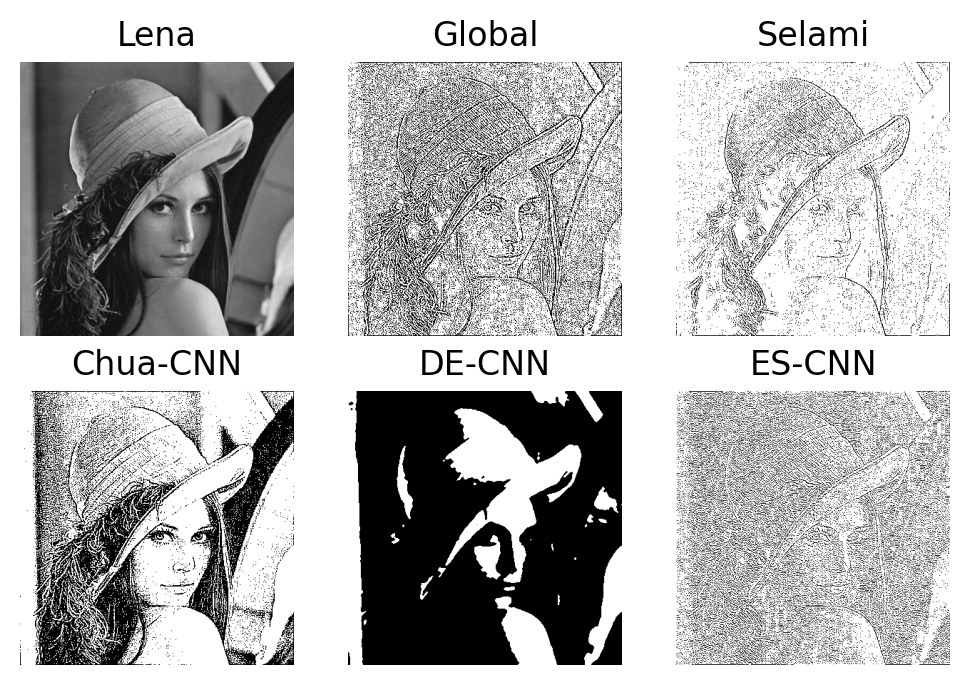

In [ ]:
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/lena.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

dim = imgEnt.shape

# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])


# ----- Global ----- #
#pG =  [4.93488187e-02, -2.26484305e-01, -1.11100007e-02, -1.26270159e-02, 4.26564270e+01, -2.59617261e-02, -3.19685278e+01, 6.24045056e-02, -1.00934957e+01, 4.28123521e+01, -2.09221465e-01]
#pG =  np.array([-0.14966108, 0.53145529, -0.16889381, -0.11542056, 63.58460309, 0.1252678, -29.91468367, 0.20578403, -23.72943881, 44.04818551, -0.33098828])
pG = np.array([0.17000624, -1.66439731, -2.26394305, 1.64457857, 58.33307036, 0.54011119, -21.21555131, 2.33031004, -32.58411392, 49.16729475, -1.64168747]) # good
hG = 0.03125
tmaxG = 1.25
imgCeNN = CeNN(matEntR, pG, dim, tmax = tmaxG, h = hG) # CeNN
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgG = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper Selami ----- #
pP = np.array([-0.2481, -5.4392, -1.2947, -7.3103, 62.7200, -0.0051, 0.0610, 0.1331, -0.0739, -34.2720, -1.6937])
hP = 0.3
tmaxP = 9.0
imgCeNN = CeNN(matEntR, pP, dim, tmax = tmaxP, h = hP) # CeNN
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgP = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper DE-CNN ----- #
pDE = np.array([-5.9791, -2.3636, -5.9905, -0.5346, -14.8176, 0.0304, -0.0198, 0.0049, -0.0453, 15.0325, 1.1570])
hDE = 1.3937/2.0
tmaxDE = hDE*4
imgCeNN = CeNN(matEntR, pDE, dim, tmax = tmaxDE, h = hDE) # CeNN
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgDE = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper ES-CNN ----- #
pES = np.array([-0.0188, -7.2196, -1.6024, -2.2306, 20.8999, -0.0397, 0.3402, -0.0362, -0.2233, -0.2497, -3.3014])
hES = 0.3
tmaxES = hES*20
imgCeNN = CeNN(matEntR, pES, dim, tmax = tmaxES, h = hES) # CeNN
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgES = imgCeNN.numpy() # Guarda en formato numpy

# ----- Chua ----- #
pCh = np.array([0.0, 0.0, 0.0, 0.0, 2.0, -1.0, -1.0, -1.0, -1.0, 8.0, -0.5])
hCh = 0.1
tmaxCh = 7.0
imgCeNN = CeNN(matEntR, pCh, dim, tmax = tmaxCh, h = hCh) # CeNN
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgCh = imgCeNN.numpy() # Guarda en formato numpy

fig, axes = plt.subplots(nrows = 2, ncols = 3, dpi = 200)
axes[0,0].imshow(imgEnt, cmap = 'gray')
axes[0,0].set_title("Lena")
axes[0,0].axis('off')
axes[0,1].imshow(imgG, cmap = 'gray')
axes[0,1].set_title("Global")
axes[0,1].axis('off')
axes[0,2].imshow(imgP, cmap = 'gray')
axes[0,2].set_title("Selami")
axes[0,2].axis('off')
axes[1,0].imshow(imgCh, cmap = 'gray')
axes[1,0].set_title("Chua-CNN")
axes[1,0].axis('off')
axes[1,1].imshow(imgDE, cmap = 'gray')
axes[1,1].set_title("DE-CNN")
axes[1,1].axis('off')
axes[1,2].imshow(imgES, cmap = 'gray')
axes[1,2].set_title("ES-CNN")
axes[1,2].axis('off')

# guardar la imagen en formato JPG
cv2.imwrite('EDLenaInput.png', imgEnt)
cv2.imwrite('EDLenaTrained.png', imgG)
cv2.imwrite('EDLenaSalemi.png', imgP)
cv2.imwrite('EDLenaChua.png', imgCh)
cv2.imwrite('EDLenaDE.png', imgDE)
cv2.imwrite('EDLenaES.png', imgES)

Plantillas: [ -0.10670936  20.38874436 -21.45379781  12.59946828  54.3960652
  -1.07520018   2.6313561   27.07886721   3.47226092  59.06013202
 -18.97814193]
Tiempo máximo: 1.1. Paso de tiempo: 0.03125
Correlación: 0.9000245332717896


True

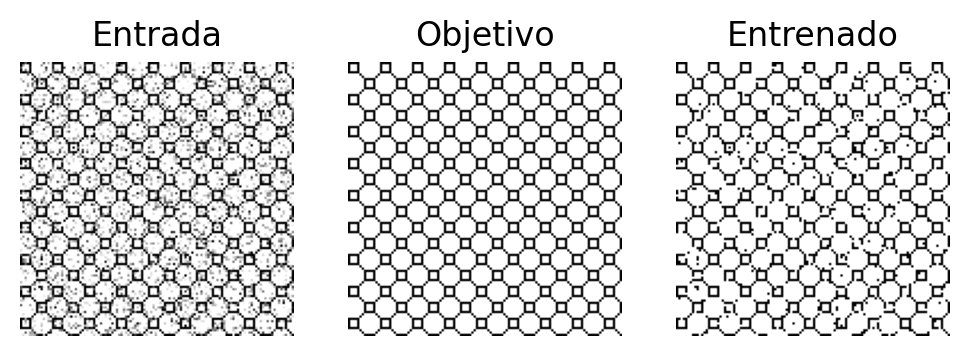

In [ ]:
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Ruido0_120x120_50.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_120x120.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)
# Valores obtenidos
pG = np.array([-0.10670936, 20.38874436, -21.45379781, 12.59946828, 54.3960652, -1.07520018, 2.6313561, 27.07886721, 3.47226092, 59.06013202, -18.97814193])
hG = 0.03125
tmaxG = 1.1
dim = imgEnt.shape
# Obtiene el valor de matObj
matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)
#matObj = tf.reshape(matObj, shape = [1, dim[0], dim[1], 1])
# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])
# Validación
imgCeNN = CeNN(matEntR, pG, dim, tmax = tmaxG, h = hG)
# Correlación
#imgCeNN = tf.reshape(imgCeNN, shape = [dim[0], dim[1]])
corr = correlacion(imgCeNN, matObj)
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN)))
#imgCeNN = tf.reshape(imgCeNN, shape = [dim[0], dim[1]])
matSal = imgCeNN.numpy()

print("Plantillas: {}".format(pG))
print("Tiempo máximo: {}. Paso de tiempo: {}".format(tmaxG, hG))
#print("Finess: {}".format(fit))
print("Correlación: {}".format(corr))
#print("CS = {}, LimSB = {}, Limites = {}, epocas = {}".format(CS, LimSB, Limites, epocas))

fig, axes = plt.subplots(nrows = 1, ncols = 3, dpi = 200)
axes[0].imshow(imgEnt, cmap = 'gray')
axes[0].axis('off')
axes[0].set_title("Entrada")
axes[1].imshow(imgObj, cmap = 'gray')
axes[1].axis('off')
axes[1].set_title("Objetivo")
axes[2].imshow(matSal, cmap = 'gray')
axes[2].axis('off')
axes[2].set_title("Entrenado")

import cv2

# guardar la imagen en formato JPG
cv2.imwrite('NRInput.png', imgEnt)
cv2.imwrite('NRObjective.png', imgObj)
cv2.imwrite('NROut.png', matSal)

Correlación Global = 0.9000245332717896
Correlación Nakai = 0.8338561058044434
Correlación Tsuruta = 0.8266825079917908


True

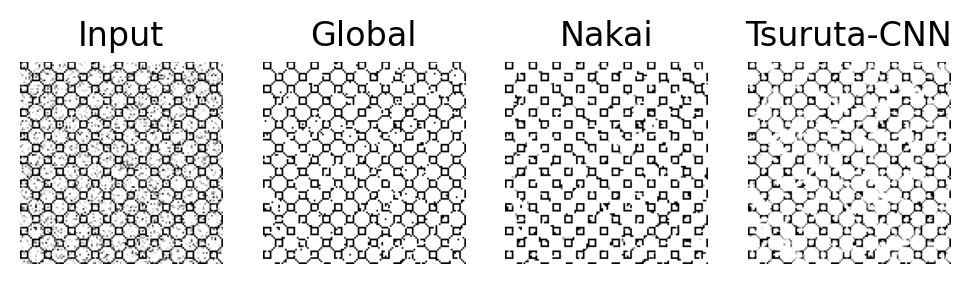

In [ ]:
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Ruido0_120x120_50.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_120x120.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)
#imgObj = -1.0*imgObj
# Valores obtenidos

dim = imgEnt.shape
# Obtiene el valor de matObj
matObj = tf.convert_to_tensor(imgObj, dtype = tf.float32)

# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])


# ----- Global ----- #
pG = np.array([-0.10670936, 20.38874436, -21.45379781, 12.59946828, 54.3960652, -1.07520018, 2.6313561, 27.07886721, 3.47226092, 59.06013202, -18.97814193])
hG = 0.03125
tmaxG = 1.1
imgCeNN = CeNN(matEntR, pG, dim, tmax = tmaxG, h = hG) # CeNN
fitG = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgG = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper Nakai ----- #
pP = np.array([0.0, 3.0, 0.0, 3.0, 2.0, 0.0, 0.0, 0.0, 0.0, 6.0, 1.0])
hP = 0.01
tmaxP = hP*50
imgCeNN = CeNN(matEntR, pP, dim, tmax = tmaxP, h = hP) # CeNN
fitP = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgP = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper Tsuruta ----- #
pDE = np.array([1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0])
hDE = 0.01
tmaxDE = hDE*50
imgCeNN = CeNN(matEntR, pDE, dim, tmax = tmaxDE, h = hDE) # CeNN
fitDE = correlacion(imgCeNN, matObj) # Correlación
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgDE = imgCeNN.numpy() # Guarda en formato numpy

# ----- Imprime valores ----- #
print("Correlación Global = {}".format(fitG))
print("Correlación Nakai = {}".format(fitP))
print("Correlación Tsuruta = {}".format(fitDE))

fig, axes = plt.subplots(nrows = 1, ncols = 4, dpi = 200)
axes[0].imshow(imgEnt, cmap = 'gray')
axes[0].set_title("Input")
axes[0].axis('off')
axes[1].imshow(imgG, cmap = 'gray')
axes[1].set_title("Global")
axes[1].axis('off')
axes[2].imshow(imgP, cmap = 'gray')
axes[2].set_title("Nakai")
axes[2].axis('off')
axes[3].imshow(imgDE, cmap = 'gray')
axes[3].set_title("Tsuruta-CNN")
axes[3].axis('off')

# guardar la imagen en formato JPG
cv2.imwrite('NRCompInput.png', imgEnt)
cv2.imwrite('NRCompTrained.png', imgG)
cv2.imwrite('NRCompNakai.png', imgP)
cv2.imwrite('NRCompTsuruta.png', imgDE)

True

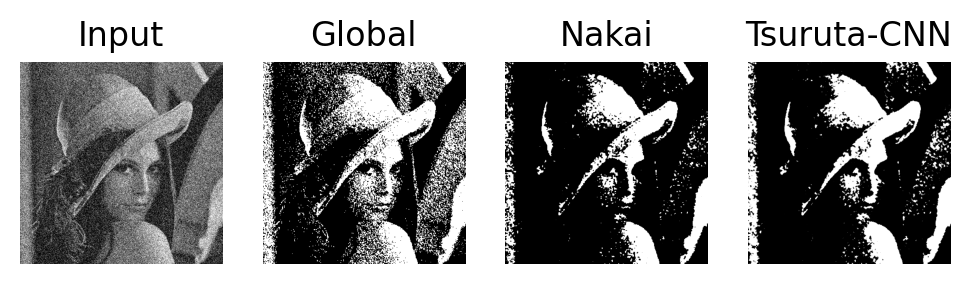

In [ ]:
# Lee la imagen de entrenamiento
#imgEnt = Image.open("./Imagenes/LenaNoise2.jpg")
imgEnt = Image.open("./Imagenes/LenaGrayNoise.png")
#imgEnt = Image.open("./Imagenes/EDLenaTrained.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)
dim = imgEnt.shape

# Matriz de entrada con valores CeNN
matEntA = 1.0 - (2.0 * imgEnt) / 255.0
matEntR = tf.convert_to_tensor(matEntA, dtype = tf.float32)
matEntR = tf.reshape(matEntR, shape = [1, dim[0], dim[1], 1])

# ----- Global ----- #
pG = np.array([-0.10670936, 20.38874436, -21.45379781, 12.59946828, 54.3960652, -1.07520018, 2.6313561, 27.07886721, 3.47226092, 59.06013202, -18.97814193])
hG = 0.03125
tmaxG = 1.1
imgCeNN = CeNN(matEntR, pG, dim, tmax = tmaxG, h = hG) # CeNN
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgG = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper Nakai ----- #
pP = np.array([0.0, 3.0, 0.0, 3.0, 2.0, 0.0, 0.0, 0.0, 0.0, 6.0, 1.0])
hP = 0.01
tmaxP = hP*50
imgCeNN = CeNN(matEntR, pP, dim, tmax = tmaxP, h = hP) # CeNN
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgP = imgCeNN.numpy() # Guarda en formato numpy

# ----- Paper Tsuruta ----- #
pDE = np.array([1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0])
hDE = 0.01
tmaxDE = hDE*50
imgCeNN = CeNN(matEntR, pDE, dim, tmax = tmaxDE, h = hDE) # CeNN
imgCeNN = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgCeNN))) # Valores 0 a 255
imgDE = imgCeNN.numpy() # Guarda en formato numpy

fig, axes = plt.subplots(nrows = 1, ncols = 4, dpi = 200)
axes[0].imshow(imgEnt, cmap = 'gray')
axes[0].set_title("Input")
axes[0].axis('off')
axes[1].imshow(imgG, cmap = 'gray')
axes[1].set_title("Global")
axes[1].axis('off')
axes[2].imshow(imgP, cmap = 'gray')
axes[2].set_title("Nakai")
axes[2].axis('off')
axes[3].imshow(imgDE, cmap = 'gray')
axes[3].set_title("Tsuruta-CNN")
axes[3].axis('off')

# guardar la imagen en formato JPG
cv2.imwrite('NRRealInput.png', imgEnt)
cv2.imwrite('NRRealTrained.png', imgG)
cv2.imwrite('NRRealNakai.png', imgP)
cv2.imwrite('NRRealTsuruta.png', imgDE)

# Lectura Matlab

In [ ]:
def correlacion2(imgEnt, imgObj):
    # Convierte la imgEnt a valores entre 0 y 255
    #img = tf.multiply(0.5, tf.multiply(255.0, tf.subtract(1.0, imgEnt)))
    imgX = tf.convert_to_tensor(imgEnt, dtype = tf.float32)
    imgY = tf.convert_to_tensor(imgObj, dtype = tf.float32)

    zPmean = tf.math.reduce_mean(imgX)
    tPmean = tf.math.reduce_mean(imgY)

    numerador = tf.math.reduce_sum(tf.multiply(tf.subtract(imgX, zPmean), tf.subtract(imgY, tPmean)))

    denA = tf.subtract(imgX, zPmean)
    denB = tf.subtract(imgY, tPmean)
    denAA = tf.multiply(denA, denA)
    denBB = tf.multiply(denB, denB)
    denAAS = tf.math.reduce_sum(denAA)
    denBBS = tf.math.reduce_sum(denBB)
    denominador = tf.sqrt(tf.multiply(denAAS, denBBS))
    
    if(denominador != 0.0):
        CD = numerador / denominador
        C = CD.numpy()
    else:
        print("denominador = 0.0")
        C = -1.0

    # Asegura que no sea negativo
    #if C < 0.0:
    #    C = 1.5
    #print("C = ", C)

    return C

In [ ]:
imgEntrada = Image.open("./Imagenes/lena.png")
imgEntrada = imgEntrada.convert('L')
imgEntrada = np.array(imgEntrada)
imgUsuario = scipy.io.loadmat('./Imagenes/imgUsuario.mat')
imgUsuario2 = scipy.io.loadmat('./Imagenes/imgUsuario2.mat')
imgUsuario3 = scipy.io.loadmat('./Imagenes/imgUsuario3.mat')
imgUsuario4 = scipy.io.loadmat('./Imagenes/imgUsuario4.mat')
imgProg = scipy.io.loadmat('./Imagenes/imgFPGA.mat')

In [ ]:
imgUser = imgUsuario['imgUsuario']
imgUser2 = imgUsuario2['imgUsuario']
imgUser3 = imgUsuario3['imgUsuario']
imgUser4 = imgUsuario4['imgUsuario']
imgFPGA = imgProg['imgFPGA']

In [ ]:
corr = correlacion2(imgUser, imgFPGA)
print("corr = {}".format(corr))
corr = correlacion2(imgUser2, imgFPGA)
print("corr = {}".format(corr))
corr = correlacion2(imgUser3, imgFPGA)
print("corr = {}".format(corr))
corr = correlacion2(imgUser4, imgFPGA)
print("corr = {}".format(corr))

corr = 0.8942935466766357
corr = 0.9058626890182495
corr = 0.9069855213165283
corr = 0.9069855213165283


(-0.5, 383.5, 383.5, -0.5)

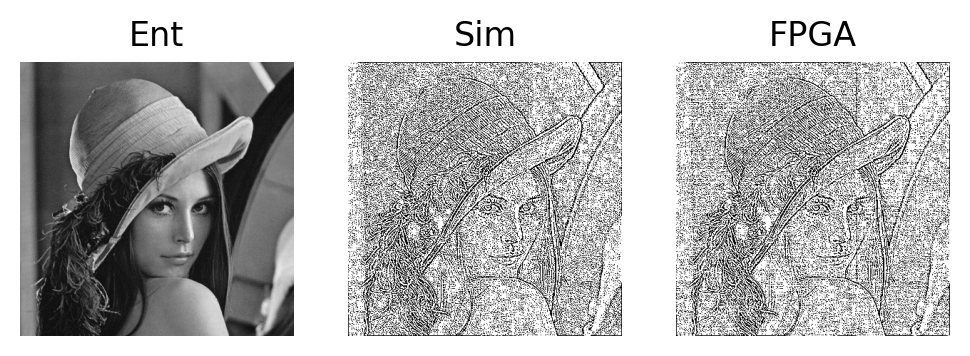

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, dpi = 200)
axes[0].imshow(imgEntrada, cmap = 'gray')
axes[0].set_title("Ent")
axes[0].axis('off')
axes[1].imshow(imgUser3, cmap = 'gray')
axes[1].set_title("Sim")
axes[1].axis('off')
axes[2].imshow(imgFPGA, cmap = 'gray')
axes[2].set_title("FPGA")
axes[2].axis('off')

In [ ]:
# guardar la imagen en formato PNG
cv2.imwrite('matUsuario3.png', imgUser3)
cv2.imwrite('matFPGA.png', imgFPGA)
cv2.imwrite('matEnt.png', imgEntrada)

In [ ]:
imgEntradaNR = Image.open("./Imagenes/NoisyLena-AWGN-with-standard-deviation-35.png")
imgEntradaNR = imgEntradaNR.convert('L')
imgEntradaNR = np.array(imgEntradaNR)
imgUsuarioNR = scipy.io.loadmat('./Imagenes/imgUsuario_NR.mat')
imgProgNR = scipy.io.loadmat('./Imagenes/imgFPGA_NR.mat')

In [ ]:
imgUser_NR = imgUsuarioNR['imgEnt']
imgFPGA_NR = imgProgNR['imgFPGA']

In [ ]:
corr = correlacion2(imgUser_NR, imgFPGA_NR)
print("corr = {}".format(corr))

corr = 0.9853451251983643


(-0.5, 253.5, 253.5, -0.5)

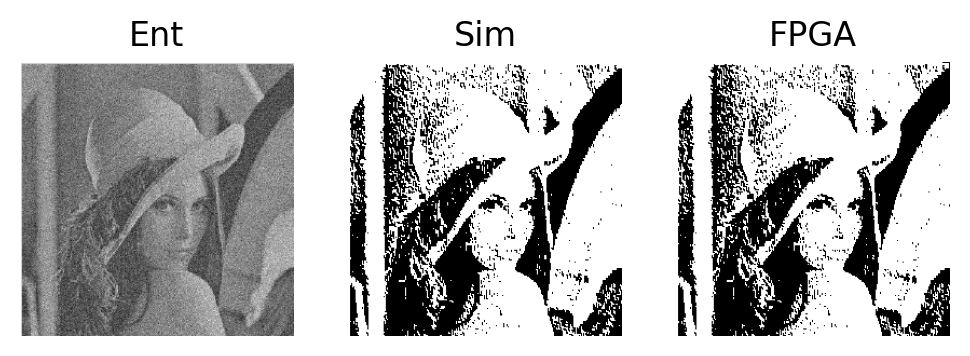

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, dpi = 200)
axes[0].imshow(imgEntradaNR, cmap = 'gray')
axes[0].set_title("Ent")
axes[0].axis('off')
axes[1].imshow(imgUser_NR, cmap = 'gray')
axes[1].set_title("Sim")
axes[1].axis('off')
axes[2].imshow(imgFPGA_NR, cmap = 'gray')
axes[2].set_title("FPGA")
axes[2].axis('off')

In [ ]:
# guardar la imagen en formato PNG
cv2.imwrite('matUsuario_NR.png', imgEntradaNR)
cv2.imwrite('matFPGA_NR.png', imgUser_NR)
cv2.imwrite('matEnt_NR.png', imgFPGA_NR)

True

# Tesis

In [ ]:
# ----- Leer las matrices CeNN ----- #
# Lee la imagen de entrenamiento
imgEnt = Image.open("./Imagenes/Ruido0_120x120_50.png")
imgEnt = imgEnt.convert('L')
imgEnt = np.array(imgEnt)

imgObj = Image.open("./Imagenes/Objetivo0_120x120.png")
imgObj = imgObj.convert('L')
imgObj = np.array(imgObj)

# Paso de tiempo y tiempo máximo de procesamiento
h = 0.03125
tmax = 1.1

# Parametros para el entrenamiento ABC
CS = 24*4
LimSB = 12
Limites = (-64.0, 64.0)
epocas = 1000

# Parametros simplex
simplex = (1.0, 2.0, 0.5)

# Entrenamiento
print("Comienza el entrenamiento")
y = TrainCeNN(imgEnt, imgObj, LimSB = LimSB, CS = CS, Limites = Limites, epocas = epocas, tmax = tmax, h = h, simplex = simplex)